# Character-level text generator for Sunthorn Phu with Pytorch

### Importing the libraries

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.parallel import DataParallel
from torch.utils.data import Dataset, DataLoader

import os
import glob
import random as rnd
import numpy as np
import pickle
import time
import string

import matplotlib.pyplot as plt
from tqdm import tqdm

### Loading the dataset txt

In [3]:
# Set the root folder
root_folder='.'

# Set the filename
filename='TextAfterNormalize.txt'

# Path to the data folder
DATA_PATH = 'Dataset'
model_dir = 'Model'
dict_dir = 'Dict'


# Set the path where the text for training is stored
train_path = os.path.join(DATA_PATH, filename)
# Set a seed random
seed = 1

In [4]:
def load_text_data(filename):
    sentences = []
    with open(filename, 'r') as reader:
        for line in reader:
            if len(line) > 1:
                sentences.append(line[:-1])
    return sentences

def clean_text(sentences, alpha=False):
    ''' Cleaning process of the text'''
    if alpha:
        # Remove non alphabetic character
        cleaned_text = [''.join([t.lower() for t in text if t.isalpha() or t.isspace()]) for text in sentences]
    else:
        # Simply lower the characters
        cleaned_text = [t.lower() for t in sentences]
    # Remove any emoty string
    cleaned_text = [t for t in cleaned_text if t!='']
    
    return cleaned_text

In [5]:
sentences = load_text_data(train_path)
print('Number of sentences: ', len(sentences))
print(sentences[:20])

Number of sentences:  65258
['จะมีคู่มิได้อยู่ประคองเชย ต้องละเลยดวงใจไว้ไกลตา', 'ถึงทุกข์ใครในโลกที่โศกเศร้า ไม่เหมือนเราภุมรินถวิลหา', 'จะพลัดพรากจากกันไม่ทันลา ใช้แต่ตาต่างถ้อยสุนทรวอน', 'โอ้จำใจไกลนุชสุดสวาท จึงนิราศเรื่องรักเป็นอักษร', 'ให้เห็นอกตกยากเมื่อจากจร ไปดงดอนแดนป่าพนาวัน', 'กับศิษย์น้องสองนายล้วนชายหนุ่ม น้อยกับพุ่มเพื่อนไร้ในไพรสัณฑ์', 'กับนายแสงแจ้งทางกลางอารัญ จะพากันแรมทางไปต่างเมือง', 'ถึงยามสองล่องลำนาวาเลื่อน พอดวงเดือนดั้นเมฆขึ้นเหลืองเหลือง', 'ถึงวัดแจ้งแสงจันทร์จำรัสเรือง แลชำเลืองเหลียวหลังหลั่งน้ำตา', 'เป็นห่วงหนึ่งถึงชนกที่ปกเกล้า จะแสนเศร้าครวญคอยละห้อยหา', 'ทั้งจากแดนแสนห่วงดวงกานดา โอ้อุรารุ่มร้อนอ่อนกำลัง', 'ถึงสามปลื้มพี่นี้ร่ำปล้ำแต่ทุกข์ สุดจะปลุกใจปลื้มให้ลืมหลัง', 'ขออารักษ์หลักประเทศนิเวศน์วัง เทพทั้งเมืองฟ้าสุราลัย', 'ขอฝากน้องสองรามารดาด้วย เอ็นดูช่วยปกครองให้ผ่องใส', 'ตัวข้าบาทจะนิราศออกแรมไพร ให้พ้นภัยคลาดแคล้วอย่าแพ้วพาน', 'ถึงสำเพ็งเก๋งตั้งริมฝั่งน้ำ แพประจำจอดเรียงเคียงขนาน', 'มีซุ้มซอกตรอกนางเจ้าประจาน ยังสำราญร้องขับไม่หลับลง', 'โอ้ธานีศรี

In [6]:
sentences = clean_text(sentences, False)
sentences = ' '.join(sentences)
print('Number of characters: ', len(sentences))
print(sentences[:100])

Number of characters:  3471447
จะมีคู่มิได้อยู่ประคองเชย ต้องละเลยดวงใจไว้ไกลตา ถึงทุกข์ใครในโลกที่โศกเศร้า ไม่เหมือนเราภุมรินถวิลห


### Creating the dictionary

 (char2int) and  (int2char).

In [7]:
class CharVocab: 
    ''' Create a Vocabulary for '''
    def __init__(self, type_vocab,pad_token='<PAD>', eos_token='<EOS>', unk_token='<UNK>'): #Initialization of the type of vocabulary
        self.type = type_vocab
        self.int2char = []
        if pad_token !=None:
            self.int2char += [pad_token]
        if eos_token !=None:
            self.int2char += [eos_token]
        if unk_token !=None:
            self.int2char += [unk_token]
        self.char2int = {}
        
    def __call__(self, text): 
        chars = set(''.join(text))
        self.int2char += list(chars)
        self.char2int = {char: ind for ind, char in enumerate(self.int2char)}
        

In [8]:
vocab = CharVocab('char',None,None,'<UNK>')
vocab(sentences)
print('Length of vocabulary: ', len(vocab.int2char))
print('Int to Char: ', vocab.int2char)
print('Char to Int: ', vocab.char2int)

Length of vocabulary:  74
Int to Char:  ['<UNK>', 'ณ', 'ซ', '.', 'ฺ', 'ำ', 'ะ', 'ม', 'ด', 'น', 'จ', 'อ', '้', 'ห', 'บ', 'ฬ', 'ส', 'ํ', 'ฮ', 'ย', 'ิ', '็', 'ฉ', 'ฏ', 'ใ', 'ธ', 'ฦ', 'ไ', 'ู', 'ศ', 'แ', '๊', 'ฝ', 'ผ', '์', 'ล', '่', 'ว', 'ี', 'ฌ', 'ษ', 'ป', ' ', 'ฃ', 'ค', '๋', '-', 'ั', 'ท', 'ื', 'ต', 'ฑ', 'ุ', 'ฎ', 'ฆ', 'ๅ', 'ร', 'พ', 'ญ', 'เ', 'โ', 'ภ', 'ง', 'ฐ', 'ึ', 'ฟ', 'ถ', 'ฯ', 'ช', 'า', 'ก', 'ฤ', 'ฒ', 'ข']
Char to Int:  {'<UNK>': 0, 'ณ': 1, 'ซ': 2, '.': 3, 'ฺ': 4, 'ำ': 5, 'ะ': 6, 'ม': 7, 'ด': 8, 'น': 9, 'จ': 10, 'อ': 11, '้': 12, 'ห': 13, 'บ': 14, 'ฬ': 15, 'ส': 16, 'ํ': 17, 'ฮ': 18, 'ย': 19, 'ิ': 20, '็': 21, 'ฉ': 22, 'ฏ': 23, 'ใ': 24, 'ธ': 25, 'ฦ': 26, 'ไ': 27, 'ู': 28, 'ศ': 29, 'แ': 30, '๊': 31, 'ฝ': 32, 'ผ': 33, '์': 34, 'ล': 35, '่': 36, 'ว': 37, 'ี': 38, 'ฌ': 39, 'ษ': 40, 'ป': 41, ' ': 42, 'ฃ': 43, 'ค': 44, '๋': 45, '-': 46, 'ั': 47, 'ท': 48, 'ื': 49, 'ต': 50, 'ฑ': 51, 'ุ': 52, 'ฎ': 53, 'ฆ': 54, 'ๅ': 55, 'ร': 56, 'พ': 57, 'ญ': 58, 'เ': 59, 'โ': 60, 'ภ': 61, 'ง': 62, 'ฐ': 63, 

### Save the dictionary

In [9]:
print(dict_dir)

Dict


In [10]:
# Check or create the directory where dictionary will be saved
if not os.path.exists(dict_dir): # Make sure that the folder exists
    os.makedirs(dict_dir)
    
# Save the dictionary to data path dir  
with open(os.path.join(dict_dir, 'char_dict.pkl'), "wb") as f:
    pickle.dump(vocab.char2int, f)

with open(os.path.join(dict_dir, 'int_dict.pkl'), "wb") as f:
    pickle.dump(vocab.int2char, f)

### Create the input data and labels for training

In [11]:
def one_hot_encode(indices, dict_size):
    features = np.eye(dict_size, dtype=np.float32)[indices.flatten()]
    features = features.reshape((*indices.shape, dict_size))
    return features

def encode_text(input_text, vocab, one_hot = False):
    output = [vocab.char2int.get(character,0) for character in input_text]
    
    if one_hot:
    # One hot encode every integer of the sequence
        dict_size = len(vocab.char2int)
        return one_hot_encode(output, dict_size)
    else:
        return np.array(output)

In [12]:
# Encode the train dataset
train_data = encode_text(sentences, vocab, one_hot = False)

# Create the input sequence, from 0 to len-1
input_seq=train_data[:-1]
# Create the target sequence, from 1 to len. It is right-shifted one place
target_seq=train_data[1:]
print('\nOriginal text:')
print(sentences[:100])
print('\nEncoded text:')
print(train_data[:100])
print('\nInput sequence:')
print(input_seq[:100])
print('\nTarget sequence:')
print(target_seq[:100])


Original text:
จะมีคู่มิได้อยู่ประคองเชย ต้องละเลยดวงใจไว้ไกลตา ถึงทุกข์ใครในโลกที่โศกเศร้า ไม่เหมือนเราภุมรินถวิลห

Encoded text:
[10  6  7 38 44 28 36  7 20 27  8 12 11 19 28 36 41 56  6 44 11 62 59 68
 19 42 50 12 11 62 35  6 59 35 19  8 37 62 24 10 27 37 12 27 70 35 50 69
 42 66 64 62 48 52 70 73 34 24 44 56 24  9 60 35 70 48 38 36 60 29 70 59
 29 56 12 69 42 27  7 36 59 13  7 49 11  9 59 56 69 61 52  7 56 20  9 66
 37 20 35 13]

Input sequence:
[10  6  7 38 44 28 36  7 20 27  8 12 11 19 28 36 41 56  6 44 11 62 59 68
 19 42 50 12 11 62 35  6 59 35 19  8 37 62 24 10 27 37 12 27 70 35 50 69
 42 66 64 62 48 52 70 73 34 24 44 56 24  9 60 35 70 48 38 36 60 29 70 59
 29 56 12 69 42 27  7 36 59 13  7 49 11  9 59 56 69 61 52  7 56 20  9 66
 37 20 35 13]

Target sequence:
[ 6  7 38 44 28 36  7 20 27  8 12 11 19 28 36 41 56  6 44 11 62 59 68 19
 42 50 12 11 62 35  6 59 35 19  8 37 62 24 10 27 37 12 27 70 35 50 69 42
 66 64 62 48 52 70 73 34 24 44 56 24  9 60 35 70 48 38 36 60 29 70 59 29
 5

In [13]:
# Save the encoded text to a file
encoded_data = os.path.join(dict_dir, 'input_data.pkl')
with open(encoded_data, 'wb') as fp:
    pickle.dump(train_data, fp)

In [14]:
print('Encoded characters: ',train_data[100:102])
print('One-hot-encoded characters: ',one_hot_encode(train_data[100:102], 75))

Encoded characters:  [69 42]
One-hot-encoded characters:  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]]


In [15]:
class MyDatasetText(Dataset):
    def __init__(self, features_seq, label_seq, batch_size, seq_len):
        self.features_seq = features_seq
        self.label_seq = label_seq
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.num_batches = len(features_seq) // (batch_size * seq_len)
        if self.num_batches == 0:
            raise ValueError("No batches created. Use smaller batch size or sequence length.")
        self.rounded_len = self.num_batches * batch_size * seq_len

    def __len__(self):
        return self.num_batches

    def __getitem__(self, idx):
        start_idx = idx * self.seq_len
        end_idx = start_idx + self.batch_size * self.seq_len

        x = torch.from_numpy(self.features_seq[start_idx:end_idx]).view(self.batch_size, self.seq_len)
        y = torch.from_numpy(self.label_seq[start_idx:end_idx]).view(self.batch_size, self.seq_len)

        return x, y

def batch_generator_sequence1(features_seq, label_seq, batch_size, seq_len):
    dataset = MyDatasetText(features_seq, label_seq, batch_size, seq_len)
    dataloader = DataLoader(dataset, batch_size=None)

    return dataloader


In [17]:
class RNNModel1(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, n_layers, drop_rate=0.2):
        super(RNNModel1, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_size = embedding_size
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        self.drop_rate = drop_rate
        self.char2int = None
        self.int2char = None

        # Defining the layers
#         self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn_layers = nn.ModuleList()
        for i in range(3):
            self.rnn_layers.append(nn.LSTM(embedding_size, hidden_dim, dropout=drop_rate, batch_first=True))
        self.dropout = nn.Dropout(drop_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, state):
#         embed_seq = self.dropout(self.embedding(x))
        for layer in self.rnn_layers:
#             rnn_out, state = layer(embed_seq, state)
            rnn_out, state = layer(x, state)
            embed_seq = self.dropout(rnn_out)

        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)
        logits = self.fc(rnn_out)
        return logits, state

    def init_state(self, device, batch_size=1):
        return (
            torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
            torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        )

    def predict(self, input):
        logits, hidden = self.forward(input)
        probs = F.softmax(logits)
        probs = probs.view(input.size(0), input.size(1), probs.size(1))
        return probs, hidden


## Training the model

In [18]:
def train_main(model, optimizer, loss_fn, batch_data, num_batches, val_batches, batch_size, seq_len, n_epochs, clip_norm, device):
    # Training Run
    epoch_losses = []
    epoch_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(1, n_epochs + 1):
        # Store the loss and accuracy in every batch iteration
        batch_losses = []
        batch_accs = []

        hidden = model.init_state(device, batch_size)

        # Train all the batches in every epoch
        progress_desc = "Epoch {}/{}".format(epoch, n_epochs + 1)
        for i in tqdm(range(num_batches - val_batches), desc=progress_desc):
            # Get the next batch data for input and target
            input_batch, target_batch = batch_data.dataset[i]
            # One-hot encode the input data
            input_batch = one_hot_encode(input_batch, model.vocab_size)
            # Transform to tensor
            input_data = torch.from_numpy(input_batch).to(device)
            target_data = target_batch.to(device)

            # Create a new variable for the hidden state, necessary to calculate the gradients
            hidden = tuple(var.data for var in hidden)

            # Set the model to train and prepare the gradients
            model.train()
            optimizer.zero_grad()  # Clears existing gradients from previous epoch
            # Pass Forward the RNN
            output, hidden = model(input_data, hidden)
            output = output.to(device)

            # Calculate the loss
            target_data = target_data.view(batch_size * seq_len)
            loss = loss_fn(output, target_data)
            batch_losses.append(loss.item())

            # Calculate the accuracy
            _, predicted = torch.max(output, 1)
            accuracy = torch.sum(predicted == target_data).item() / (batch_size * seq_len)
            batch_accs.append(accuracy)

            loss.backward()  # Does backpropagation and calculates gradients
            # Clip gradient norm
            nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()  # Updates the weights accordingly

        epoch_losses.append(np.mean(batch_losses))
        epoch_accs.append(np.mean(batch_accs))

        # Evaluate the model on validation data
        model.eval()
        val_hidden = model.init_state(device, batch_size)
        val_batch_losses = []
        val_batch_accs = []

        progress_desc = "Val Epoch {}/{}".format(epoch, n_epochs + 1)
        for i in tqdm(range(val_batches), desc=progress_desc):
            # Get the next batch data for input and target
            input_batch, target_batch = batch_data.dataset[i]
            # One-hot encode the input data
            input_batch = one_hot_encode(input_batch, model.vocab_size)
            # Transform to tensor
            input_data = torch.from_numpy(input_batch).to(device)
            target_data = target_batch.to(device)

            # Create a new variable for the hidden state, necessary to calculate the gradients
            hidden = tuple(var.data for var in val_hidden)

            # Pass Forward the RNN
            output, hidden = model(input_data, hidden)
            output = output.to(device)

            # Calculate the loss
            target_data = target_data.view(batch_size * seq_len)
            loss = loss_fn(output, target_data)
            val_batch_losses.append(loss.item())

            # Calculate the accuracy
            _, predicted = torch.max(output, 1)
            accuracy = torch.sum(predicted == target_data).item() / (batch_size * seq_len)
            val_batch_accs.append(accuracy)

        val_losses.append(np.mean(val_batch_losses))
        val_accs.append(np.mean(val_batch_accs))

        model.train()
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Train Loss: {:.4f}".format(epoch_losses[-1]), end=' ')
        print("Train Acc: {:.4f}".format(epoch_accs[-1]), end=' ')
        print("Val Loss: {:.4f}".format(val_losses[-1]), end=' ')
        print("Val Acc: {:.4f}".format(val_accs[-1]))

        # Check if current validation accuracy is the best so far
        if val_accs[-1] > best_val_acc:
            best_val_acc = val_accs[-1]
            best_model_state = model.state_dict()

    # Load the best model state dictionary
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print('The best model have val acc is :', best_val_acc)

    return (epoch_losses, epoch_accs, val_losses, val_accs), model


In [19]:
# Define hyperparameters for training
n_epochs = 50
lr=0.005
batch_size=1024
maxlen=64
clip_norm=5
val_fraction = 0.1

# Define hypeparameters of the model
hidden_dim = 256 #64
n_layers = 1
embedding_size=len(vocab.char2int)
dict_size = len(vocab.char2int)
drop_rate = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(device, num_gpus)
# Set a seed to reproduce experiments
torch.manual_seed(seed)
print(dict_size, embedding_size,  hidden_dim, n_layers)

cuda 1
74 74 256 1


In [20]:
# Instantiate the model with hyperparameters
model = RNNModel1(dict_size,embedding_size, hidden_dim, n_layers)
# We'll also set the model to the device that we defined earlier (default is CPU)
    
model = model.to(device)
print(model)
# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

/home/diwwergg/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RNNModel1(
  (rnn_layers): ModuleList(
    (0-2): 3 x LSTM(74, 256, batch_first=True, dropout=0.2)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=74, bias=True)
)


In [21]:
print(len(input_seq))
input_seq = input_seq[:]
target_seq = target_seq[:]
print(len(input_seq))

3471446
3471446


In [22]:
def save_model(model, model_dir, n_layers, embedding_size, hidden_dim, dict_size, drop_rate):
    # Save Model
    if not os.path.exists(model_dir): # Make sure that the folder exists
        os.makedirs(model_dir)
    # Save the parameters used to construct the model
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'wb') as f:
        model_info = {
            'n_layers': n_layers,
            'embedding_dim': embedding_size,
            'hidden_dim': hidden_dim,
            'vocab_size': dict_size,
            'drop_rate': drop_rate
        }
        torch.save(model_info, f)

    model_run_path = os.path.join(model_dir, 'model_run.pth')
    with open(model_run_path, 'wb') as f:
        torch.save(model, f)

    # Save the model parameters
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'wb') as f:
        torch.save(model.state_dict(), f)
    print('Save Model Success')

In [23]:
# Calculate the number of batches to train
num_batches = len(input_seq) // (batch_size*maxlen)
val_batches = int(num_batches*val_fraction)
# Create the batch data generator
batch_data = batch_generator_sequence1(input_seq, target_seq, batch_size, maxlen)
losses_accs, model = train_main(model, optimizer, criterion, batch_data, num_batches, val_batches, batch_size, 
                    maxlen, n_epochs, clip_norm, device)
save_model(model, model_dir, n_layers, embedding_size, hidden_dim, dict_size, drop_rate)

Val Epoch 1/51: 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch: 1/50............. Train Loss: 3.6508 Train Acc: 0.0780 Val Loss: 3.4732 Val Acc: 0.1197


Val Epoch 2/51: 100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch: 2/50............. Train Loss: 3.2756 Train Acc: 0.1766 Val Loss: 2.9504 Val Acc: 0.2223


Val Epoch 3/51: 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch: 3/50............. Train Loss: 2.8267 Train Acc: 0.2394 Val Loss: 2.7342 Val Acc: 0.2546


Val Epoch 4/51: 100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


Epoch: 4/50............. Train Loss: 2.6514 Train Acc: 0.2694 Val Loss: 2.5967 Val Acc: 0.2758


Val Epoch 5/51: 100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch: 5/50............. Train Loss: 2.5143 Train Acc: 0.2995 Val Loss: 2.4418 Val Acc: 0.3208


Val Epoch 6/51: 100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


Epoch: 6/50............. Train Loss: 2.4041 Train Acc: 0.3278 Val Loss: 2.3338 Val Acc: 0.3452


Val Epoch 7/51: 100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


Epoch: 7/50............. Train Loss: 2.2986 Train Acc: 0.3556 Val Loss: 2.2329 Val Acc: 0.3728


Val Epoch 8/51: 100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch: 8/50............. Train Loss: 2.1557 Train Acc: 0.3950 Val Loss: 2.0888 Val Acc: 0.4152


Val Epoch 9/51: 100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


Epoch: 9/50............. Train Loss: 2.0078 Train Acc: 0.4368 Val Loss: 1.9230 Val Acc: 0.4609


Val Epoch 10/51: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch: 10/50............. Train Loss: 1.8471 Train Acc: 0.4809 Val Loss: 1.7798 Val Acc: 0.4988


Val Epoch 11/51: 100%|██████████| 5/5 [00:00<00:00,  7.73it/s]


Epoch: 11/50............. Train Loss: 1.7053 Train Acc: 0.5201 Val Loss: 1.6060 Val Acc: 0.5503


Val Epoch 12/51: 100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


Epoch: 12/50............. Train Loss: 1.5514 Train Acc: 0.5642 Val Loss: 1.4749 Val Acc: 0.5877


Val Epoch 13/51: 100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


Epoch: 13/50............. Train Loss: 1.4136 Train Acc: 0.6037 Val Loss: 1.3481 Val Acc: 0.6252


Val Epoch 14/51: 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch: 14/50............. Train Loss: 1.2901 Train Acc: 0.6390 Val Loss: 1.2266 Val Acc: 0.6598


Val Epoch 15/51: 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch: 15/50............. Train Loss: 1.1734 Train Acc: 0.6728 Val Loss: 1.1125 Val Acc: 0.6931


Val Epoch 16/51: 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch: 16/50............. Train Loss: 1.0828 Train Acc: 0.6987 Val Loss: 1.0299 Val Acc: 0.7181


Val Epoch 17/51: 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch: 17/50............. Train Loss: 0.9968 Train Acc: 0.7239 Val Loss: 0.9348 Val Acc: 0.7477


Val Epoch 18/51: 100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch: 18/50............. Train Loss: 0.9021 Train Acc: 0.7533 Val Loss: 0.8683 Val Acc: 0.7634


Val Epoch 19/51: 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch: 19/50............. Train Loss: 0.8388 Train Acc: 0.7706 Val Loss: 0.8155 Val Acc: 0.7775


Val Epoch 20/51: 100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch: 20/50............. Train Loss: 0.7772 Train Acc: 0.7891 Val Loss: 0.7698 Val Acc: 0.7905


Val Epoch 21/51: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch: 21/50............. Train Loss: 0.7149 Train Acc: 0.8077 Val Loss: 0.6620 Val Acc: 0.8302


Val Epoch 22/51: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch: 22/50............. Train Loss: 0.6524 Train Acc: 0.8273 Val Loss: 0.6445 Val Acc: 0.8300


Val Epoch 23/51: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch: 23/50............. Train Loss: 0.5881 Train Acc: 0.8493 Val Loss: 0.6040 Val Acc: 0.8402


Val Epoch 24/51: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch: 24/50............. Train Loss: 0.5830 Train Acc: 0.8454 Val Loss: 0.5285 Val Acc: 0.8722


Val Epoch 25/51: 100%|██████████| 5/5 [00:00<00:00,  7.67it/s]


Epoch: 25/50............. Train Loss: 0.5174 Train Acc: 0.8699 Val Loss: 0.4865 Val Acc: 0.8821


Val Epoch 26/51: 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch: 26/50............. Train Loss: 0.4706 Train Acc: 0.8836 Val Loss: 0.4458 Val Acc: 0.8979


Val Epoch 27/51: 100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch: 27/50............. Train Loss: 0.4278 Train Acc: 0.8989 Val Loss: 0.3742 Val Acc: 0.9261


Val Epoch 28/51: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch: 28/50............. Train Loss: 0.3902 Train Acc: 0.9101 Val Loss: 0.5519 Val Acc: 0.8406


Val Epoch 29/51: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch: 29/50............. Train Loss: 0.3943 Train Acc: 0.9050 Val Loss: 0.4257 Val Acc: 0.8904


Val Epoch 30/51: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch: 30/50............. Train Loss: 0.3431 Train Acc: 0.9237 Val Loss: 0.3700 Val Acc: 0.9140


Val Epoch 31/51: 100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch: 31/50............. Train Loss: 0.3210 Train Acc: 0.9303 Val Loss: 0.4344 Val Acc: 0.8810


Val Epoch 32/51: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch: 32/50............. Train Loss: 0.2744 Train Acc: 0.9476 Val Loss: 0.4617 Val Acc: 0.8654


Val Epoch 33/51: 100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch: 33/50............. Train Loss: 0.2512 Train Acc: 0.9536 Val Loss: 0.3103 Val Acc: 0.9264


Val Epoch 34/51: 100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch: 34/50............. Train Loss: 0.2881 Train Acc: 0.9353 Val Loss: 0.1947 Val Acc: 0.9777


Val Epoch 35/51: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s]


Epoch: 35/50............. Train Loss: 0.2510 Train Acc: 0.9464 Val Loss: 0.2694 Val Acc: 0.9444


Val Epoch 36/51: 100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch: 36/50............. Train Loss: 0.1581 Train Acc: 0.9835 Val Loss: 0.1666 Val Acc: 0.9803


Val Epoch 37/51: 100%|██████████| 5/5 [00:00<00:00,  7.67it/s]


Epoch: 37/50............. Train Loss: 0.2202 Train Acc: 0.9555 Val Loss: 0.1476 Val Acc: 0.9860


Val Epoch 38/51: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch: 38/50............. Train Loss: 0.1969 Train Acc: 0.9592 Val Loss: 0.4517 Val Acc: 0.8615


Val Epoch 39/51: 100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch: 39/50............. Train Loss: 0.1891 Train Acc: 0.9660 Val Loss: 0.1268 Val Acc: 0.9887


Val Epoch 40/51: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch: 40/50............. Train Loss: 0.1060 Train Acc: 0.9899 Val Loss: 0.7115 Val Acc: 0.7927


Val Epoch 41/51: 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]


Epoch: 41/50............. Train Loss: 0.2771 Train Acc: 0.9309 Val Loss: 0.1335 Val Acc: 0.9873


Val Epoch 42/51: 100%|██████████| 5/5 [00:00<00:00,  7.67it/s]


Epoch: 42/50............. Train Loss: 0.0854 Train Acc: 0.9958 Val Loss: 0.0921 Val Acc: 0.9928


Val Epoch 43/51: 100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Epoch: 43/50............. Train Loss: 0.0981 Train Acc: 0.9866 Val Loss: 0.4494 Val Acc: 0.8619


Val Epoch 44/51: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch: 44/50............. Train Loss: 0.2624 Train Acc: 0.9331 Val Loss: 0.1167 Val Acc: 0.9893


Val Epoch 45/51: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch: 45/50............. Train Loss: 0.0710 Train Acc: 0.9968 Val Loss: 0.0771 Val Acc: 0.9938


Val Epoch 46/51: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch: 46/50............. Train Loss: 0.0538 Train Acc: 0.9979 Val Loss: 0.0857 Val Acc: 0.9906


Val Epoch 47/51: 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]


Epoch: 47/50............. Train Loss: 0.2547 Train Acc: 0.9324 Val Loss: 0.1107 Val Acc: 0.9890


Val Epoch 48/51: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch: 48/50............. Train Loss: 0.0619 Train Acc: 0.9973 Val Loss: 0.0670 Val Acc: 0.9945


Val Epoch 49/51: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]


Epoch: 49/50............. Train Loss: 0.0444 Train Acc: 0.9983 Val Loss: 0.0579 Val Acc: 0.9951


Val Epoch 50/51: 100%|██████████| 5/5 [00:00<00:00,  7.68it/s]

Epoch: 50/50............. Train Loss: 0.0395 Train Acc: 0.9985 Val Loss: 0.0540 Val Acc: 0.9954
The best model have val acc is : 0.9953704833984375
Save Model Success


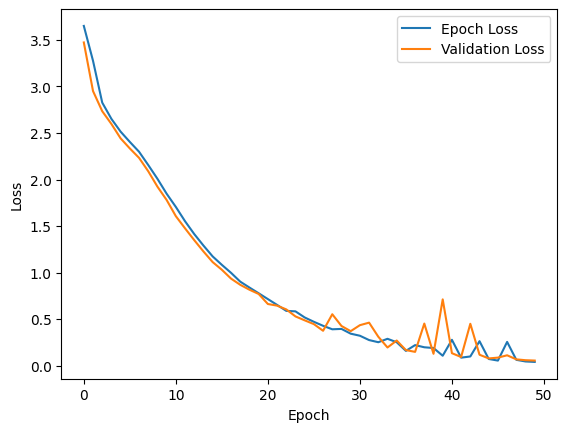

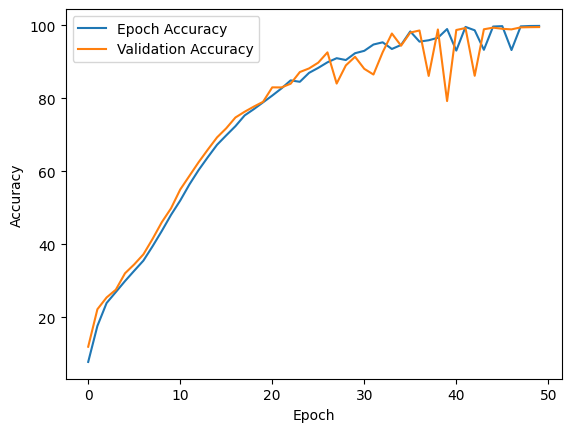

In [24]:
(epoch_losses, epoch_accs, val_losses, val_accs) = losses_accs
epoch_accs = np.array(epoch_accs) * 100
val_accs = np.array(val_accs) * 100

plt.plot(epoch_losses, label='Epoch Loss')
plt.plot(val_losses, label='Validation Loss')
# plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot((epoch_accs), label='Epoch Accuracy')
plt.plot((val_accs), label='Validation Accuracy')
# plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Load Model and Load data dict

In [54]:
# Path to the data folder
DATA_PATH = 'Dataset'
model_dir = 'Model'
dict_dir = 'Dict'

# Files Data
char_dict_file = 'char_dict.pkl'
input_data_file = 'input_data.pkl'
int_dict_file = 'int_dict.pkl'

# file Model
model_info_file = 'model_info.pth'
model_file = 'model.pth'# dict

In [56]:
# Load the dictionary from the pickle file
char_dict_path = os.path.join(dict_dir, char_dict_file)
input_data_path = os.path.join(dict_dir, input_data_file)
int_dict_path = os.path.join(dict_dir, int_dict_file)

# Load the dictionary from the pickle file
def load_pickle(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data

char_dict = load_pickle(char_dict_path)
input_data = load_pickle(input_data_path)
int_dict = load_pickle(int_dict_path)

In [57]:
# Set vocap 
vocab = CharVocab('char',None,None,'<UNK>')
vocab.int2char = int_dict
vocab.char2int = char_dict

print('Length of vocabulary: ', len(vocab.int2char))
print('Int to Char: ', vocab.int2char)
print('Char to Int: ', vocab.char2int)


Length of vocabulary:  74
Int to Char:  ['<UNK>', 'ณ', 'ซ', '.', 'ฺ', 'ำ', 'ะ', 'ม', 'ด', 'น', 'จ', 'อ', '้', 'ห', 'บ', 'ฬ', 'ส', 'ํ', 'ฮ', 'ย', 'ิ', '็', 'ฉ', 'ฏ', 'ใ', 'ธ', 'ฦ', 'ไ', 'ู', 'ศ', 'แ', '๊', 'ฝ', 'ผ', '์', 'ล', '่', 'ว', 'ี', 'ฌ', 'ษ', 'ป', ' ', 'ฃ', 'ค', '๋', '-', 'ั', 'ท', 'ื', 'ต', 'ฑ', 'ุ', 'ฎ', 'ฆ', 'ๅ', 'ร', 'พ', 'ญ', 'เ', 'โ', 'ภ', 'ง', 'ฐ', 'ึ', 'ฟ', 'ถ', 'ฯ', 'ช', 'า', 'ก', 'ฤ', 'ฒ', 'ข']
Char to Int:  {'<UNK>': 0, 'ณ': 1, 'ซ': 2, '.': 3, 'ฺ': 4, 'ำ': 5, 'ะ': 6, 'ม': 7, 'ด': 8, 'น': 9, 'จ': 10, 'อ': 11, '้': 12, 'ห': 13, 'บ': 14, 'ฬ': 15, 'ส': 16, 'ํ': 17, 'ฮ': 18, 'ย': 19, 'ิ': 20, '็': 21, 'ฉ': 22, 'ฏ': 23, 'ใ': 24, 'ธ': 25, 'ฦ': 26, 'ไ': 27, 'ู': 28, 'ศ': 29, 'แ': 30, '๊': 31, 'ฝ': 32, 'ผ': 33, '์': 34, 'ล': 35, '่': 36, 'ว': 37, 'ี': 38, 'ฌ': 39, 'ษ': 40, 'ป': 41, ' ': 42, 'ฃ': 43, 'ค': 44, '๋': 45, '-': 46, 'ั': 47, 'ท': 48, 'ื': 49, 'ต': 50, 'ฑ': 51, 'ุ': 52, 'ฎ': 53, 'ฆ': 54, 'ๅ': 55, 'ร': 56, 'พ': 57, 'ญ': 58, 'เ': 59, 'โ': 60, 'ภ': 61, 'ง': 62, 'ฐ': 63, 

In [65]:
# Load the model's parameters
model_info_path = os.path.join(model_dir, model_info_file)
with open(model_info_path, 'rb') as f:
    model_info = torch.load(f)
    

# Create an instance of the model using the loaded information
model = RNNModel1(
    vocab_size=model_info['vocab_size'],
    embedding_size=model_info['embedding_dim'],
    hidden_dim=model_info['hidden_dim'],
    n_layers=model_info['n_layers'],
    drop_rate=model_info['drop_rate']
)

# Load the model parameters
model.load_state_dict(torch.load(os.path.join(model_dir, model_file)))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)


RNNModel1(
  (rnn_layers): ModuleList(
    (0-2): 3 x LSTM(74, 256, batch_first=True, dropout=0.2)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=74, bias=True)
)


/home/diwwergg/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Predict an input sequence

In [59]:
def sample_from_probs(probs, top_n=10):
    _, indices = torch.sort(probs)
    # set probabilities after top_n to 0
    probs[indices.data[:-top_n]] = 0
    #print(probs.shape)
    sampled_index = torch.multinomial(probs, 1)
    return sampled_index

def predict_probs(model, device, hidden, character, vocab):
    # One-hot encoding our input to fit into the model
    character = np.array([[vocab.char2int[c] for c in character]])
    character = one_hot_encode(character, model.vocab_size)
    character = torch.from_numpy(character)
    character = character.to(device)
    
    out, hidden = model(character, hidden)

    prob = nn.functional.softmax(out[-1], dim=0).data
    return prob, hidden

def format_text(text_predicted, line = 4):
    count = 0
    text = ''
    text_custom = text_predicted.split(' ')
    for i in range(len(text_custom)):
        if (i+1) % 2 == 0 :
            text_custom[i] += '\n'
            count += 1
        else :
            text_custom[i] += ' '
        text += text_custom[i]
        if count == line:
            break
    return text

In [60]:
def generate_from_text(model, device, out_len, vocab, top_n=1, start='หัวใจพี่นั้นเองแหลกสลาย') :
    model.eval() # eval mode
    
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Generate the initial hidden state
    state = model.init_state(device, 1)
    
    # Warm up the initial state, predicting on the initial string
    for ch in chars:
        probs, state = predict_probs(model, device, state, ch, vocab)
        next_index = sample_from_probs(probs, top_n)

    # Now pass in the previous characters and get a new one
    for ii in range(size):
        probs, state = predict_probs(model, device, state, chars, vocab)
        next_index = sample_from_probs(probs, top_n)
        chars.append(vocab.int2char[next_index.data[0]])

    return ''.join(chars)

In [66]:
text_predicted = generate_from_text(model, device, 300, vocab, 2, 'ไป')
text = format_text(text_predicted)
print(len(text))
print(text)

183
ไปในอาศัก เขมใหนดระเดทิงเปลงะคงคว
มิ่งนิ่วสาลับล้ามตรวงรำ อยรายมาค้านยากพระชายุ่ง
ให้หาวยเหินทาวด้วยจะวิกห่าง ตะโข้งเหลือกำโรงพญ้อยเจรี
ฉรอมรคอแพรระคอนคลอน เป็นสางฝ้างน้อยหน้าสารันน์



In [67]:
texts = ['แต่', 'เป็น', 'ฝ่าย', 'จึง', 'ไม่']
for t in texts:
    text_predicted = generate_from_text(model, device, 300, vocab, 2, str(t))
    text = format_text(text_predicted)
    print(len(text))
    print(text)

208
แต่งีแลิลขวาดล้ายนาน แม้นไว้มีหลักก็ชมร้างมาตาว
เออเคชทยงเการเกษมสนัง ถึงนาไลตลงดิ่งไพรสัณฑ์
มาเดิดมัปราชิ่งติดสิบทั้ง เหมือนชื่อตั้งทิศขทรวททวนไป
ดูหญิสายชาวิ้วโศกผันเมิ่ง มีใครละอึกเหมือนมื่นอุตุลแต่เตื่อน

168
เป็นอานาวา ไม่พวัดหมายตรอมสรัด
พั้น่าตามีแต่ไสลขัน มัจง้ายลันไกลสักติมา
ก็ติดมัตริ้งดู้นกระสียัก แสนเซิดเดินมาชาแจ่วระยัง
ไม่เจ้นไปให้อายันสาวาย หังก่าศปลาอยังพาลมายุง

183
ฝ่ายพุ่มก้าม ขว้างขวงสว่ทวงมแขว้างว่าทะงา
โอ้นึงไก่รัดเลน้ามอารัม จงครับคันกูปกลับกย่างไกล้ไว
หันทุ่งเชลาะทุ่ง ถึงบางชั้มตามตลิงตามระนัย
จงระรำเดิดร่องรวยองรุณร ทั้งหนีพริยมถึงบางพระ

183
จึงไม่รอกเทวาส เขะโถนดงามาเหมือนกินัตง์ดัง
ว่าช่วยพุ่มไม่แมงไป มี่นึกคำม่อนมา
ลงใจเจ็บเกลีดอยล้วนทับเท้า ต้องกด้อย่องจะนองเน่าอัด
ตะลึงแลตลอดตล้องว้องกอนน้อง ถึงยามยอกพิศานยาดป้านวัด

165
ไม่แน้งแทศ ลิจจบิ้ไไท่จีดไม้ดังแสง
ตะลังไม่ค่าเดีมวรถวง เห็นของมิไดวใส
ไม่ชื่อแสมปสายชัง นี่สนร่ำลำให้มิได้พบเหมือน
ได้ทุ่งโล้งแสดชายเนินชานี จนสูบทิกทราสรรเขยเมื่อ



In [51]:
def predict_char(model, device, character, vocab):
    # One-hot encoding our input to fit into the model
    character = np.array([[vocab.char2int[c] for c in character]])
    character = one_hot_encode(character, model.vocab_size)
    character = torch.from_numpy(character)
    character = character.to(device)
    
    model.eval() # eval mode
    state = model.init_state(device, 1)
    print(character.shape, state[0].shape, state[1].shape)
    out, hidden = model(character, state)
    prob = nn.functional.softmax(out[-1], dim=0).data
    
    # Taking the class with the highest probability score from the output
    m = torch.max(prob, dim=0)
    char_ind = torch.max(prob, dim=0)[1].item()
    return vocab.int2char[char_ind], hidden


In [52]:
t,_ = predict_char(model, device, 'ฝ่าย', vocab)
print('Initial string: ', t)

torch.Size([1, 4, 74]) torch.Size([1, 1, 256]) torch.Size([1, 1, 256])
Initial string:  เ
